In [79]:
pip install textblob

     |████████████████████████████████| 645kB 2.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install twitter

     |████████████████████████████████| 61kB 2.4MB/s eta 0:00:01


In [11]:
!pip install tweepy

     |████████████████████████████████| 153kB 5.6MB/s eta 0:00:01


In [32]:
pip install -U scikit-learn

  Using cached https://files.pythonhosted.org/packages/e9/57/8a9889d49d0d77905af5a7524fb2b468d2ef5fc723684f51f5ca63efed0d/scikit_learn-0.21.3-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Found existing installation: scikit-learn 0.21.2
    Uninstalling scikit-learn-0.21.2:
      Successfully uninstalled scikit-learn-0.21.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tweepy, json
import twitter
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import time
import ssl
import requests
import csv

In [2]:
from requests.exceptions import Timeout, ConnectionError
from requests.packages.urllib3.exceptions import ReadTimeoutError

## Option 1
Source: https://github.com/feconroses/gather-tweets-from-stream/blob/master/stream.py

This Python script allows you to connect to the Twitter Standard Search API, gather historical tweets from up to 7 days ago that contain a specific keyword, hashtag or mention, and save them into a CSV file under the following column categories:

- Tweet content: text of the tweet
- Date: date and hour of the tweet
- User: name of the author of the tweet
- Source used to post the tweet (for example, Twitter Web Client or Buffer)
- Tweet ID
- Tweet URL

In [3]:
access_key = "3395163311-L3kfrmBLjeT2wid9IUIrmhWhg9xhwoWIuGVdtdB"
access_secret = "c7yzOy6ZP7fSspILaPkPFhaIp65P9g2rzcSTqG4OgSqDD"
consumer_key = "3h2dbtJm7BchEn8NhszxhqGXF"
consumer_secret = "kLLwKYTIZg4FyNlECC3jxI34ITTTMI22KWuq3uZjpzZid2kLVR"

In [4]:
# Handling authentication with Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)

In [5]:
# Create a wrapper for the API provided by Twitter
api = tweepy.API(auth)

In [77]:
#test video Siraj Raval
public_tweets = api.search('Trump')

In [82]:
#test video Siraj Raval
from textblob import textblob
for tweet in public_tweets:
    print(tweet.text)
    analysis = textblob(tweet.text)
    print(analysis.sentiment)

ImportError: cannot import name 'textblob' from 'textblob' (/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/textblob/__init__.py)

In [6]:
# Setting up the keywords, hashtag or mentions we want to listen
#keywords = ["#SEO", "SEO"]
keywords = ["Trump", "Ukraine"]

In [7]:
# Set the name for CSV file  where the tweets will be saved
filename = "tweets"

In [8]:
# We need to implement StreamListener to use Tweepy to listen to Twitter
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        try:
            #saves the tweet object
            tweet_object = status
            
            # checks if its a extended tweet (>140 characters)
            if 'extended_tweet' in tweet_object._json:
                tweet = tweet_object.extended_tweet['full_text']
            else: 
                tweet = tweet_object.text
                
            '''Convert all named and numeric character references
            (e.g. &gt;, &#62;, &#x3e;) in the string s to the
            corresponding Unicode characters'''
            tweet = (tweet.replace('&amp;', '&').replace('&lt;', '<')
                     .replace('&gt;', '>').replace('&quot;', '"')
                     .replace('&#39;', "'").replace(';', " ")
                     .replace(r'\u', " "))
            
            #Save the keyword that matches the stream
            keyword_matches = []
            for word in keywords: 
                if word.lower() in tweet.lower():
                    keyword_matches.extend([word])
            
            keywords_strings = ", ".join(str(x) for x in keyword_matches)
            
            #Save other information from the tweet
            user = status.author.screen_name
            timeTweet = status.created_at
            source = status.source
            tweetId = status.id
            tweetUrl = "https://twitter.com/statuses/" + str(tweetId)
            
            #Exclude retweets, too many mentions and too many hashtags
            if not any((('RT @' in tweet, 'RT' in tweet,
                       tweet.count('@') >= 2, tweet.count('#') >= 3))):
                
                #Saves the tweet information in a new row of the CSV file 
                writer.writerow([tweet, keywords_strings, timeTweet,
                                user, source, tweetId, tweetUrl])
        
        except Exception as e: 
            print('Encountered Exception:', e)
            pass

In [9]:
def work():
    #Opening a CSV file to save the gathered tweets
    with open(filename+".csv", 'w') as file:
        global writer
        writer = csv.writer(file)
        
        #Add a header row to the CSV
        writer.writerow(["Tweet", "Matched Keywords", "Date", "User", "Source", "Tweet ID", "Tweet URL"])
        
        #Initializing the twitter streap Stream
        try:
            streamingAPI = tweepy.streaming.Stream(auth, StreamListener())
            streamingAPI.filter(track=keywords)
        
        # Stop temporarily when hitting Twitter rate Limit
        except tweepy.RateLimitError:
            print("RateLimitError...waiting ~15 minutes to continue")
            time.sleep(1001)
            streamingAPI = tweepy.streaming.Stream(auth, StreamListener())
            streamingAPI.filter(track=[keywords])
        
        # Stop temporarily when getting a timeout or connection error
        except (Timeout, ssl.SSLError, ReadTimeoutError,
                ConnectionError) as exc:
            print("Timeout/connection error...waiting ~15 minutes to continue")
            time.sleep(1001)
            streamingAPI = tweepy.streaming.Stream(auth, StreamListener())
            streamingAPI.filter(track=[keywords])
        
        # Stop temporarily when getting other errors
        except tweepy.TweepError as e:
            if 'Failed to send request:' in e.reason:
                print("Time out error caught.")
                time.sleep(1001)
                streamingAPI = tweepy.streaming.Stream(auth, StreamListener())
                streamingAPI.filter(track=[keywords])
            else:
                print("Other error with this user...passing")
                pass
    if __name__ =='__main__':
        
        work()

**tweets.csv can be found in same folder as Jupyter Notebook is located. View content, length?**

In [10]:
tweetscsv = pd.read_csv('/Users/colinechabloz/Desktop/Springboard/CapstoneProject2/tweets.csv')

In [11]:
tweetscsv.head()

,Tweet Content,Date,User,Source,Tweet ID,Tweet URL
0,Evolution of Google’s News Ranking Algorithm #...,2019-10-31 23:58:25,MikeBlazerX,IFTTT,1190055454614982659,https://twitter.com/statuses/1190055454614982659
1,How To Get More Traffic! https://t.co/cd2oybk2...,2019-10-31 23:52:08,myostaff,Paper.li,1190053873471381504,https://twitter.com/statuses/1190053873471381504
2,🎃🎃Trick or Treat! Just like Frankenstein's mon...,2019-10-31 23:51:09,webitmd,HubSpot,1190053628297535490,https://twitter.com/statuses/1190053628297535490
3,Google Releases Study of 2019 Holiday Shopping...,2019-10-31 23:51:03,joeybalestrino,IFTTT,1190053601714089984,https://twitter.com/statuses/1190053601714089984
4,#seo & #funny Prison Economy Spirals As Price ...,2019-10-31 23:50:41,Seo_Santos,IFTTT,1190053510957678592,https://twitter.com/statuses/1190053510957678592


Note: Doesn't seem to contain "Trump" and "Ukraine"

## Option 2

Source: https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed

## Section A: Preparing The Test Set

**Step A.2: Authenticating our Python script**

Since we now have our Twitter Developers login credentials (i.e. API keys and Access token), we can proceed to authenticating our program. First, we need to import the Twitter library, then create an Twitter.API object with the credentials from the “safe” place we talked about, as follows:

In [12]:
twitter_api = twitter.api(consumer_key='3h2dbtJm7BchEn8NhszxhqGXF', consumer_secret='kLLwKYTIZg4FyNlECC3jxI34ITTTMI22KWuq3uZjpzZid2kLVR', access_token_key='3395163311-L3kfrmBLjeT2wid9IUIrmhWhg9xhwoWIuGVdtdB', access_token_secret='c7yzOy6ZP7fSspILaPkPFhaIp65P9g2rzcSTqG4OgSqDD')
print(twitter_api.VerifyCredentials())

TypeError: 'module' object is not callable

**QUESTION TO RAFA: WHY DOESN'T LINE ABOVE WORK?**

The last line in the previous code snippet is only there to verify that our API instance works. This will be determined based on the output we get. Run the above code and you should get something like the following JSON response:

{"created_at": "Tue Feb 12 17:48:27 +0800 2019" 'default_profile": true ............}

That is nothing crazy but some data about the access made to the API through your Twitter account. If you reach this, you’re good to go.

**Step A.3: Creating the function to build the Test set**

Now we can start on making a function that downloads the Test set that we talked about. Basically, this is going to be a function that takes a search keyword (i.e. string) as an input, searches for tweets that include this keyword and returns them as twitter.Status objects that we can iterate through.

The caveat here, though, is that Twitter limits the number of requests you can make through the API for security purposes. This limit is 180 requests per 15-minute window.
This means, we can only get up to 180 tweets using our search function every 15 minutes, which should not be a problem, as our Training set is not going to be that large anyway. For the sake of simplicity, we will limit the search to 100 tweets for now, not exceeding the allowed number of requests. Our function for searching for the tweets (i.e. Test set) will be:

In [5]:
def buildTestSet(search_keyword):
    try: 
        tweets_fetched = twitter_api.GetSearch(search_keyword, count = 100)
        
        print("Fetched " + str(len(tweets_fetched)) + " tweets for the term " + search_keyword)
        
        return [{"text":status.text, "label":None} for status in tweets_fetched]
    except:
        print("Unfortunately, something went wrong..")
        return None

As you might have expected, this function will return a list of tweets that contain our search keyword.

Note that we coupled — into a JSON object — every tweet’s text with a label that is NULL for now. This is merely because we are going to classify each tweet as Positive or Negative later on, in order to determine whether the sentiment on the search term is positive or negative, based on the majority count. This is how Sentiment Analysis pragmatically works.

Before we move on, let’s test out our function by adding the following code after the function body:

In [6]:
search_term = input("Enter a search keyword:")
testDataSet = buildTestSet(search_term)

print(testDataSet[0:4])

Enter a search keyword:trump
Unfortunately, something went wrong..


TypeError: 'NoneType' object is not subscriptable

**Observation: THIS LINE DOESN'T WORK PROBABLY BECAUSE LINE 4 FAILED**

This should print out five tweets that contain our search keyword on the Terminal of your IDE (if you’re using one). Now everything is set. We have our Test set and we can move on to building our Training set.

## Section B: Preparing The Training Set

Note that so far, we haven’t written a lot of code. This is attributed to the beauty of Python’s succinctness in syntax as well as the use of external program-ready libraries, such as RESTful APIs (Twitter API in our case).

In this section, we will also be using our Twitter API instance from the last section. However, we need to get some things out the way first. We will be using a downloadable Training set. The tweets of which were all labeled as positive or negative, depending on the content. This exactly what a Training set is for.

"A Training set is critical to the success of the model. Data is which needs to be labeled properly with no inconsistencies or incompleteness, as training will rely heavily on the accuracy of such data and the manner of acquisition."

For this task, we will be using the amazing Niek Sanders’ Corpus of over 5000 hand-classified tweets, which makes it quite reliable. There’s also a catch here. Twitter does not allow storing tweets on a personal device, even though all such data is publicly available. Therefore, the corpus includes a keyword (topic of the tweet), a label (pos/neg) and a tweet ID number for every tweet (i.e. row in our CSV corpus). You can get the file containing the corpus from the original site, or through this link of a personal repository.

Let’s backtrack for a bit. Remember the Twitter API limit we talked about? This will also apply here, as we will be using the API to get the actual tweet text through each tweet’s ID number included in the Corpus we have. This means, to download 5000 tweets, we will need to follow:

max_number_of_requests = 180
time_window = 15 minutes = 900 seconds
Therefore, the process should follow:
Repeat until end-of-file: {
    180 requests -> (900/180) sec wait
}

Let’s now write the code that does exactly that. Let’s not forget to save the tweets we retrieve through the API into a new CSV file so that we don’t have to download them every time we run the code. Our function will be as follows:

In [94]:
def buildTrainingSet(corpusFile, tweetDataFile):
    import csv
    import time
    
    corpus = []
    
    with open(corpusFile,'rb') as csvfile:
        lineReader = csv.reader(csvfile,delimiter=',', quotechar="\"")
        for row in lineReader:
            corpus.append({"tweet_id":row[2], "label":row[1], "topic":row[0]})
    
    rate_limit = 180
    sleep_time = 900/180
    
    trainingDataSet = []
    
    for tweet in corpus:
        try:
            status = twitter_api.GetStatus(tweet["tweet_id"])
            print("Tweet fetched" + status.text)
            tweet["text"] = status.text
            trainingDataSet.append(tweet)
            time.sleep(sleep_time) 
        except: 
            continue
        
        # now we write them to the empty CSV file
    with open(tweetDataFile,'wb') as csvfile:
        linewriter = csv.writer(csvfile,delimiter=',',quotechar="\"")
        for tweet in trainingDataSet:
            try:
                linewriter.writerow([tweet["tweet_id"], tweet["text"], tweet["label"], tweet["topic"]])
            except Exception as e:
                print(e)
    return trainingDataSet

This was a handful, but it’s fairly simple if we break it down into parts. Firstly, we define the function to take two inputs, both of which are file paths:

- corpusFile is the string path to the Niek Sanders’ CSV corpus file we downloaded. This file, as mentioned earlier, includes the tweet’s topic, label and id.
- tweetDataFile is the string path to the file we would like to save the full tweets in. In contrast to corpusFile, this file will include every tweet’s text as well as topic, label and id.

Next, we started with an empty list corpus. We then opened the file corpusFile and appended every tweet from the file to the list corpus.

The next segment of the code deals with getting the text of tweets based on the IDs. We loop through the tweets in corpus, calling the API on every tweet to get the Tweet.Status object of the particular tweet. Afterwards, we use that same object (status) to get the text associated with it and push it into the trainingDataSet then sleep (i.e. pause execution) for five minutes (900/180 seconds) in order to abide by the request limit we talked about.

Now let’s take the time to leave our script download the tweets (which will take hours) following our last function. We can do this using the following snippet:

In [95]:
corpusFile = "/Users/colinechabloz/Desktop/CapstoneProject2/corpus.csv"
tweetDataFile = "/Users/colinechabloz/Desktop/CapstoneProject2/tweetDataFile.csv"

trainingData = buildTrainingSet(corpusFile, tweetDataFile)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/colinechabloz/Desktop/CapstoneProject2/corpus.csv'

As soon as the code finishes executing, you will have your tweetDataFile CSV file full of tweets (~5000, as a matter of fact). If you got this far, CONGRATULATIONS !— it took me, the first time, a substantial amount of time to reach here without problems. Now we’re done with the relatively boring part. Let’s get ourselves hyped up for the upcoming section.

## Section C: Pre-processing Tweets in The Data Sets

Before we move on to the actual classification section, there is some cleaning up to do. As a matter of fact, this step is critical and usually takes a long time when building Machine Learning models. However, this will not be a problem in our task, as the data we have is relatively consistent. In other words, we know exactly what we need from it. I will express on this matter later on.

Let’s talk about what matters and what doesn’t matter in Sentiment Analysis. Words are the most important part (to an extent that we will talk about in the upcoming section). However, when it comes to things like punctuation, you cannot get the sentiment from punctuation. Therefore, punctuation does not matter to Sentiment Analysis. Moreover, tweet components like images, videos, URLs, usernames, emojis, etc. do not contribute to the polarity (whether it is positive or negative) of the tweet. However, this is only true for this application. For instance, in another application, you could have a Deep Learning image classifier that learns and predicts whether this image that the tweet contains stands for something positive (e.g. a rainbow) or negative (e.g. a tank). When it comes to the technicality, both Sentiment Analysis and Deep Learning fall under Machine Learning. In fact, you can perform Sentiment Analysis through Deep Learning, but that’s a story for another day.

So we know what we need to keep in the tweets we have and what we need to take out. This applies to both Training and Test sets. So let’s make a our pre-processor class:

In [97]:
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords

class PreProcessTweets:
    def __init__(self):
        self._stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])
    def processTweets(self, list_of_tweets):
        processedTweets=[]
        for tweet in list_of_tweets:
            processedTweets.append((self._processTweet(tweet["text"]),tweet["label"]))
        return processedTweets
    def _processTweet(self, tweet):
        tweet = tweet.lower() # convert text to lower-case
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
        tweet = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
        return [word for word in tweet if word not in self._stopwords]

That was a handful, so let’s break it down into parts. We start off by our imported libraries. re is Python’s Regular Expressions (RegEx) library, which takes care of parsing strings and modifying them in an efficient way without having to explicitly iterate through the characters comprising the particular string. We also imported ntlk, is the Natural Processing Toolkit, which is one of the most commonly used Python libraries out there. It takes care of any processing that we need to perform on text to change its form or extract certain components from it. The class constructor removes stop words. This is a relatively big topic that you can read up on later, as it is more into Natural Language Processing and less related to our topic.

The processTweets function just loops through all the tweets input into it, calling its neighboring function processTweet on every tweet in the list. The latter does the actual pre-processing by first making all the text in lower-case letters. This is merely because, in almost all programming languages, “cAr” is not interpreted the same way as “car”. Therefore, it is better to normalize all characters to be lower-case across all our data. Secondly, URLs and usernames are removed from the tweet. This is for the reasons we disclosed earlier in the article. Afterwards, the number sign (i.e. #) is removed from every hashtag, in order to avoid hashtags being processed differently. Last but not least, duplicate characters are rid off of, in order to ensure that no important word goes unprocessed even if it is spelled out in an unusual way (e.g. “caaaaar” becomes “car”). Finally, the tweet’s text is broken into words (tokenized) in order to ease its processing in the upcoming stages.

Let’s take an example. The following tweet could be present in the data set:

"@person1 retweeted @person2: Corn has got to be the most delllllicious crop in the world!!!! #corn #thoughts..."

Our pre-processor will result in the tweet looking like:

“AT_USER rt AT_USER corn has got to be the most delicious crop in the world corn thoughts”

And finally, the tokenization will result in:

{“corn”, “most”, “delicious”, “crop”, “world”, “corn”, “thoughts”}

Note that our code removed duplicate characters in words as we metioned earlier (i.e. “delllllicious” became “delicious”). However, it did not remove duplicate words (i.e. “corn”) from the text, but rather kept them. This is because duplicate word play a role in determining the polarity of the text (as we will see in the upcoming section).

We are all set to use our Pre-processor class. First, we will create a variable that refers to it (an object), and then call it on both the Training and Test sets as we discussed earlier:

In [98]:
tweetProcessor = PreProcessTweets()
preprocessedTrainingSet = tweetProcessor.processTweets(trainingData)
preprocessedTestSet = tweetProcessor.processTweets(testDataSet)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/colinechabloz/nltk_data'
    - '/Users/colinechabloz/anaconda3/nltk_data'
    - '/Users/colinechabloz/anaconda3/share/nltk_data'
    - '/Users/colinechabloz/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


Now we can move on to the most exciting part — classification. But first, let’s brush up (or touch) on our algorithm for this task: Naive Bayes Classifier.

## Section D: Naive Bayes Classifier

Without a doubt, one of the most important concepts in Computer Science and Machine Learning. It can be frustrating to get into the math of it head-first. Therefore, I will not be explaining it from the mathematical perspective.

"You don’t need to know the math to be a Computer Scientist. However, you do need to know the math to become a really good one."

I want to emphasize on the fact that I will only briefly explain Naive Bayes Classification here, as the in-depth explanation deserves its own lengthy post.

Naive Bayes Classifier is a classification algorithm that relies on Bayes’ Theorem. This theorem provides a way of calculating a type or probability called posterior probability, in which the probability of an event A occurring is reliant on probabilistic known background (e.g. event B evidence). For example, if Person_X only plays tennis when it is not raining outside, then, according to Bayesian statistics, the probability of Person_X playing tennis when it is not raining can be given as:

P(X plays | no rain) = P(no rain | X plays)*P(x plays)/P(no rain)

following Bayes’ theorem:

P(A|B) = P(B|A)*P(A)/P(B)

All you need to know for our task is that a Naive Bayes Classifier depends on the ever-famous Bayes’ theorem. Before we move on, let’s give a quick overview of the steps we will be taking next:

- Build a vocabulary (list of words) of all the words resident in our training data set.
- Match tweet content against our vocabulary — word-by-word.
- Build our word feature vector.
- Plug our feature vector into the Naive Bayes Classifier.

This might seem like a lot, but don’t worry. It is actually fairly simple and as short as it can be. Let’s take it down step-by-step.

**Step D.1: Building the vocabulary**

A vocabulary in Natural Language Processing is a list of all speech segments available for the model. In our case, this includes all the words resident in the Training set we have, as the model can make use of all of them relatively equally — at this point, to say the least. The code will look something like this:

In [99]:
def buildVocabulary(preprocessedTrainingData):
    all_words = []
    
    for (words, sentiment) in preprocessedTrainingData:
        all_words.extend(words)

    wordlist = nltk.FreqDist(all_words)
    word_features = wordlist.keys()
    
    return word_features

This is just creating a list of all_words we have in the Training set, breaking it into word features. Those word_features are basically a list of distinct words, each of which has its frequency (number of occurrences in the set) as a key.

**Step D.2: Matching tweets against our vocabulary**

This step is crucial, as we will go through all the words in our Training set (i.e. our word_features list), comparing every word against the tweet at hand, associating a number with the word following:

"label 1 (true): if word in vocabulary is resident in tweet
label 0 (false): if word in vocabulary is not resident in tweet"

This is fairly simple to code:

In [100]:
def extract_features(tweet):
    tweet_words = set(tweet)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in tweet_words)
    return features 

Given the last snippet, for every word in the word_features, we will have the JSON key ‘contains word X’, where X is the word. Every key of those will have the value True/False, according to what we said earlier about the labels — True for ‘present’ and False for ‘absent’.

**Step D.3: Building our feature vector**

Let’s now call the last two functions we have written. This will build our final feature vector, with which we can proceed on to training.

In [101]:
word_features = buildVocabulary(preprocessedTrainingData)
trainingFeatures = nltk.classify.apply_features(extract_features, preprocessedTrainingData)

NameError: name 'preprocessedTrainingData' is not defined

The NTLK built-in function apply_features does the actual feature extraction from our lists. Our final feature vector is trainingFeatures.

**Step D.4: Training the classifier**

We have finally come to the most important — and ironically the shortest — part of our task. Thanks to NLTK, it will only take us a function call to train the model as a Naive Bayes Classifier, since the latter is built into the library:

In [102]:
NBayesClassifier = nltk.NaiveBayesClassifier.train(trainingFeatures)

NameError: name 'trainingFeatures' is not defined

We’re almost done! All we have left is running the classifier training code (i.e. nltk.NaiveBayesClassifier.train()) and testing it. Note that this code could take a few minutes to execute.

## Section E: Testing The Model

Moment of truth! Let’s finish up our work by running the classifier (i.e. NBayesClassifier) on the 100 tweets that we downloaded from Twitter, according to our search term, and getting the majority vote of the labels returned by the classifier, then outputting the total positive or negative percentage (i.e. score) of the tweets. This is also going to be very simple:

In [103]:
NBResultLabels = [NBayesClassifier.classify(extract_features(tweet[0])) for tweet in preprocessedTestDataSet]

# get the majority vote
if NBResultLabels.count('positive') > NBResultLabels.count('negative'):
    print("Overall Positive Sentiment")
    print("Positive Sentiment Percentage = " + str(100*NBResultLabels.count('positive')/len(NBResultLabels)) + "%")
else: 
    print("Overall Negative Sentiment")
    print("Negative Sentiment Percentage = " + str(100*NBResultLabels.count('negative')/len(NBResultLabels)) + "%")

NameError: name 'preprocessedTestDataSet' is not defined

That’s it! Congratulations. You have created a Twitter Sentiment Analysis Python program. Note that we did not touch on the accuracy (i.e. evaluate the model) because it is not our topic for the day. There will be a post where I explain the whole model/hypothesis evaluation process in Machine Learning later on. Let’s take a final look at the full code we wrote for this task:

## Conclusion

Sentiment Analysis is an interesting way to think about the applicability of Natural Language Processing in making automated conclusions about text. It is being utilized in social media trend analysis and, sometimes, for marketing purposes. Making a Sentiment Analysis program in Python is not a difficult task, thanks to modern-day, ready-for-use libraries. This program is a simple explanation to how this kind of application works. This is only for academic purposes, as the program described here is by no means production-level.

## Option 3  DataCamp The Twitter API and Authentification

**API Authentication**

The package tweepy is great at handling all the Twitter API OAuth Authentication details for you. All you need to do is pass it your authentication credentials.

In [17]:
access_token = "3395163311-L3kfrmBLjeT2wid9IUIrmhWhg9xhwoWIuGVdtdB"
access_token_secret = "c7yzOy6ZP7fSspILaPkPFhaIp65P9g2rzcSTqG4OgSqDD"
consumer_key = "3h2dbtJm7BchEn8NhszxhqGXF"
consumer_secret = "kLLwKYTIZg4FyNlECC3jxI34ITTTMI22KWuq3uZjpzZid2kLVR"

In [14]:
# Pass OAuth details to tweepy's OAuth handler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [18]:
#define the tweet stream listener class
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api=None):
        super(MyStreamListener, self).__init__()
        self.num_tweets = 0
        self.file = open("tweets.txt", "w")

    def on_status(self, status):
        tweet = status._json
        self.file.write( json.dumps(tweet) + '\n' )
        self.num_tweets += 1
        if self.num_tweets < 100:
            return True
        else:
            return False
        self.file.close()

    def on_error(self, status):
        print(status)

**Streaming tweets**

Now that you have set up your authentication credentials, it is time to stream some tweets! We have already defined the tweet stream listener class, MyStreamListener, just as Hugo did in the introductory video. You can find the code for the tweet stream listener class here.

Your task is to create the Streamobject and to filter tweets according to particular keywords.

In [19]:
#initialize Stream listener
l = MyStreamListener()

# Create your Stream object with authentication
stream = tweepy.Stream(auth, l)

# Filter Twitter Streams to capture data by the keywords:
stream.filter(track=['clinton','trump','sanders','cruz'])

**Load and explore your Twitter data**

Now that you've got your Twitter data sitting locally in a text file, it's time to explore it! This is what you'll do in the next few interactive exercises. In this exercise, you'll read the Twitter data into a list: tweets_data.

Be aware that this is real data from Twitter and as such there is always a risk that it may contain profanity or other offensive content (in this exercise, and any following exercises that also use real Twitter data).

In [20]:
tweets_data_path = 'tweets.txt'

In [21]:
# Initialize empty list to store tweets: tweets_data
tweets_data = []

In [22]:
# Open connection to file
tweets_file = open(tweets_data_path, "r")

In [23]:
# Read in tweets and store in list: tweets_data
for line in tweets_file:
    tweet = json.loads(line)
    tweets_data.append(tweet)

# Close connection to file
tweets_file.close()

# Print the keys of the first tweet dict
print(tweets_data[0].keys())

dict_keys(['created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'filter_level', 'lang', 'timestamp_ms'])


**Twitter data to DataFrame**

Now you have the Twitter data in a list of dictionaries, tweets_data, where each dictionary corresponds to a single tweet. Next, you're going to extract the text and language of each tweet. The text in a tweet, t1, is stored as the value t1['text']; similarly, the language is stored in t1['lang']. Your task is to build a DataFrame in which each row is a tweet and the columns are 'text' and 'lang'.

In [24]:
# Build DataFrame of tweet texts and languages
df = pd.DataFrame(tweets_data, columns=['text','lang'])

# Print head of DataFrame
print(df.head())

                                                text lang
0  RT @anuraag_saxena: #Democrat comes in dressed...   en
1  RT @Strandjunker: Love Hillary, hate Hillary, ...   en
2       In Trump’s America, the academics, supported   en
3  RT @BobMagaw: Donald Trump’s unique speaking s...   en
4  RT @JonAshworth: 🚨So from his Downing Street o...   en


**A little bit of Twitter text analysis**

Now that you have your DataFrame of tweets set up, you're going to do a bit of text analysis to count how many tweets contain the words 'clinton', 'trump', 'sanders' and 'cruz'. In the pre-exercise code, we have defined the following function word_in_text(), which will tell you whether the first argument (a word) occurs within the 2nd argument (a tweet).

In [26]:
#defined the following function word_in_text(), which will tell you whether the first argument (a word) occurs within the 2nd argument (a tweet).
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)

    if match:
        return True
    return False

# Initialize list to store tweet counts
[clinton, trump, sanders, cruz] = [0, 0, 0, 0]

# Iterate through df, counting the number of tweets in which
# each candidate is mentioned
for index, row in df.iterrows():
    clinton += word_in_text('clinton', row['text'])
    trump += word_in_text('trump', row['text'])
    sanders += word_in_text('sanders', row['text'])
    cruz += word_in_text('cruz', row['text'])

**Plotting your Twitter data**

Now that you have the number of tweets that each candidate was mentioned in, you can plot a bar chart of this data. You'll use the statistical data visualization library seaborn, which you may not have seen before, but we'll guide you through. You'll first import seaborn as sns. You'll then construct a barplot of the data using sns.barplot, passing it two arguments:

a list of labels and
a list containing the variables you wish to plot (clinton, trump and so on.)
Hopefully, you'll see that Trump was unreasonably represented! We have already run the previous exercise solutions in your environment.

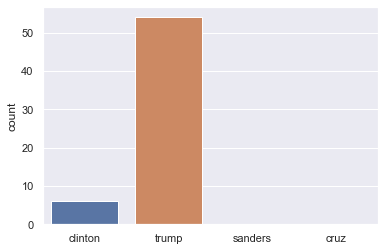

In [28]:

# Set seaborn style
sns.set(color_codes=True)

# Create a list of labels:cd
cd = ['clinton', 'trump', 'sanders', 'cruz']

# Plot histogram
ax = sns.barplot(cd, [clinton, trump, sanders, cruz])
ax.set(ylabel="count")
plt.show()

**tweets.txt is located in the same folder as Jupyter Notebook is located.**